### (MCLP) Maximum Covering Location Problem
- Cover the most customer demands with no more than $p$ facilities.
- Sets:
    - $I$: set of customers
    - $J$: set of candidate facility locations
- Parameters:
    - $h_i$: demand at customer $i$ (annual)
    - $p$: number of facilities to locate
    - $a_{ij}=\begin{cases}
            1, \quad\text{if facitlity at } j\in J \text{ can cover customer } i\in I\\
            0, \quad\text{O.W.}
        \end{cases}
        $
- Decision variables:
    - $x_j=\begin{cases}
            1, \quad\text{if a facility is installed at } j\\
            0, \quad\text{O.W.}
        \end{cases}
        $
    - $z_{ij}=\begin{cases}
            1, \quad\text{if customer } i \text{ is covered by an open facility}\\
            0, \quad\text{O.W.}
        \end{cases}
        $
        
<br>

$
\begin{split}
&\text{(MCLP)}\quad & \text{maximize}\quad \sum\limits_{i\in I}h_{i}z_{i}\\
&&\begin{split}
\text{subject to}\quad\quad &z_{i}\le\sum\limits_{j\in J}a_{ij}x_{j} & \forall i\in I\\
    \sum\limits_{j\in J}&x_{j}=p\\
    & x_{j}\in \{0, 1\}                & \forall j\in J\\
    & z_{i}\in \{0, 1\}\quad\quad\quad & \forall i\in I
\end{split}
\end{split}
$

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [4]:
# declare the parameters and sets
h = i_data['Demand'].values

I = [i for i in range(len(i_data['X'].values))]
J = [j for j in range(len(j_data['X'].values))]
A = [(i, j) for i in I for j in J]

p = 2
D = 100

a = {(i, j): int(dist_ij[i, j] <= D) for (i, j) in A}

In [5]:
# create model
mdl = Model('MCLP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)
z = mdl.addVars(I, vtype=GRB.BINARY)

In [7]:
# add objective function
mdl.ModelSense = GRB.MAXIMIZE
mdl.setObjective(quicksum(h[i]*z[i] for i in I))

In [8]:
# add the model constraints
mdl.addConstrs(z[i] <= quicksum(a[i,j]*x[j] for j in J) for i in I)
mdl.addConstr(quicksum(x[j] for j in J) == p)
mdl.update()

In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 101 rows, 120 columns and 1170 nonzeros
Model fingerprint: 0x3fbf17d0
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 5224.0396869
Presolve removed 42 rows and 42 columns
Presolve time: 0.00s
Presolved: 59 rows, 78 columns, 673 nonzeros
Variable types: 0 continuous, 78 integer (78 binary)

Root relaxation: objective 6.877949e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    6877.9492233 6877.94922  0.00%     -    0s

Explored 0 nodes (34 simplex iterations) in 0.01 secon

In [10]:
# opened locations and covered customers
opened = [j for j in J if x[j].X > 0.0]
covered = [i for i in I if z[i].X > 0.0]

In [11]:
# update the dataframes
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]
i_data['Covered'] = [int(z[i].X > 0.0) for i in I]

Text(0.5, 1.0, 'Facilities Chosen')

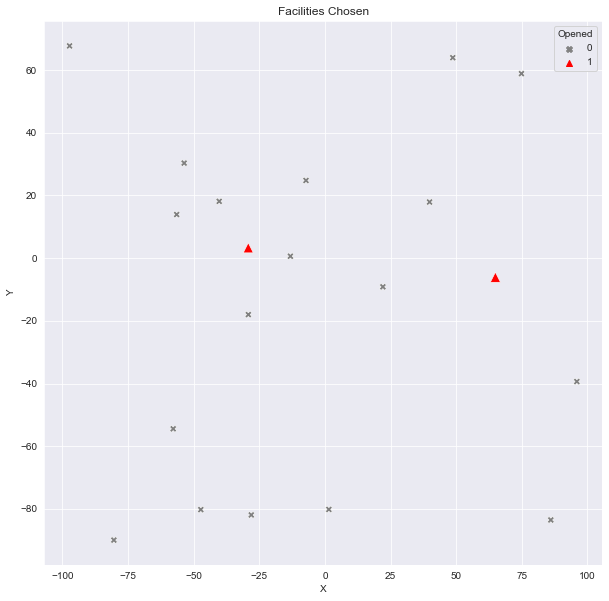

In [12]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s = [100 if i == 1 else 50 for i in j_data['Opened'].values]
sns.scatterplot(x='X', y='Y', data=j_data, hue='Opened', palette=['grey', 'red'], style='Opened', markers=('X', '^'), s=s)
plt.title('Facilities Chosen')

Text(0.5, 1.0, 'Facility Coverage')

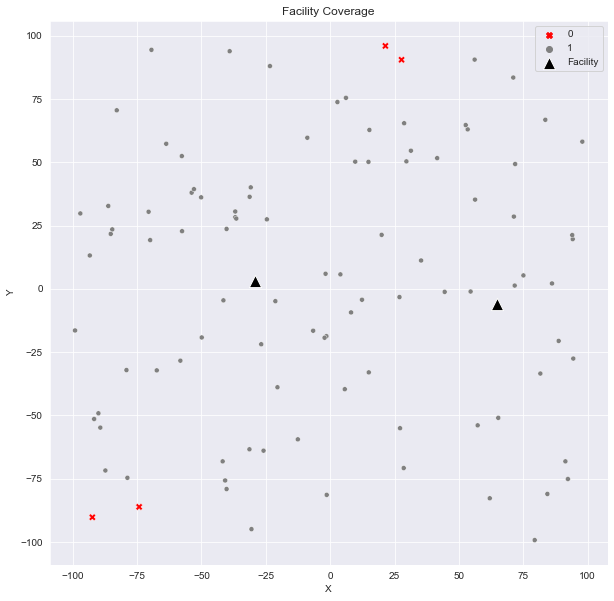

In [13]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
s = [25 if i == 1 else 50 for i in i_data['Covered'].values]
sns.scatterplot(x='X', y='Y', data=i_data, hue='Covered', palette=['red', 'grey'], style='Covered', markers=('X', 'o'), s=s)
plt.legend(labels=['Uncovered', 'Covered'])

sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=150, color='black', marker='^', label="Facility")
plt.title('Facility Coverage')

In [14]:
# find objective value
obj_val = sum([h[i]*z[i].X for i in covered])

print('Objective value = ', obj_val)

Objective value =  6877.949223286187
